# Nernst实验数据分析

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

### 读取数据

In [42]:

# 选择数据文件夹和文件，定义热电偶换算系数
# =========================================
thermo_coe = 41e-6  # T type thermocouple
data_name = "Co1-102(ipp)"
# =========================================

current_path = os.getcwd()
sample_name = data_name.split('(')[0]
folder = os.path.join(current_path, sample_name)

# 遍历文件夹下的所有文件
for root, dirs, files in os.walk(folder):
    for file in files:
        if data_name in file:
            if "thermocouple" in file:
                temp_path = os.path.join(root, file)
            else:
                scan_path = os.path.join(root, file)
            
scan_data = np.loadtxt(scan_path)
temp_data = np.loadtxt(temp_path)

# 输出数据文件，检查数据文件是否正确
print(scan_path)
print(temp_path)

c:\Users\18083\Desktop\ANE-of-Cobalt\Co1-102\20240405_Co1-102(ipp).txt
c:\Users\18083\Desktop\ANE-of-Cobalt\Co1-102\thermocouple_20240405_Co1-102(ipp).txt


### 计算温差

21.028846724375608


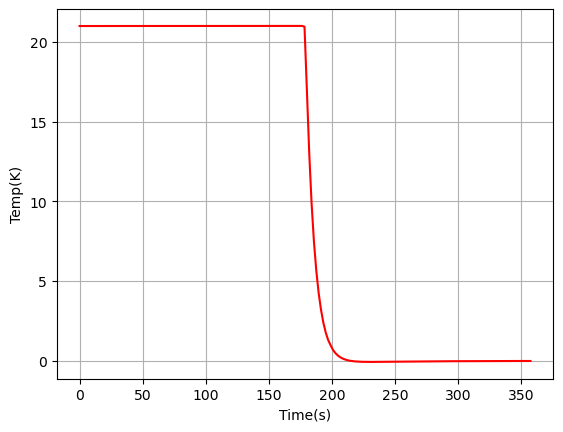

In [43]:
t = temp_data[:,0]-temp_data[0,0]
volt = temp_data[:,1]

temp = volt/thermo_coe

plt.xlabel("Time(s)")
plt.ylabel("Temp(K)")
plt.grid()
plt.plot(t, temp, 'r')

# 利用起始的若干个数据和最后的若干个数据计算温差
delta_T = np.abs(np.mean(temp[-5:]-temp[:5]))
print(delta_T)

### 计算 $S_{xy}$

$\nabla V = -S\nabla T$ 

$S_{yx} = -\frac{\partial V}{\partial y} / \frac{\partial T}{\partial x}$

$S_{yx} = -\frac{\Delta V}{W} / \frac{\Delta T}{L}$

$S_{xy} = -\frac{L\Delta V}{W\Delta T} $


0.00301 0.00186


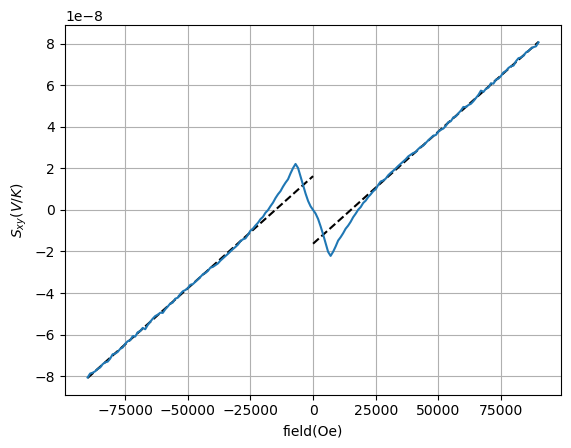

slope = 1.0786592779897548e-12 V/K/Oe
S_ANE = 1.625231499223985e-08 V/K


In [44]:
# =========================================
# sample geometry
# Co0001: L=1.84mm, W=1.58mm
# Co11-20: L=2.60mm, W=1.35mm
# Co1-102: L=3.01mm, W=1.86mm
geometry = {"Co0001": [1.84e-3, 1.58e-3], "Co11-20": [2.60e-3, 1.35e-3], "Co1-102": [3.01e-3, 1.86e-3]}
# =========================================

length = geometry[sample_name][0]
width = geometry[sample_name][1]
print(length, width)

data_len = len(scan_data)
field = scan_data[:data_len//2, 1]
# 来回数据取平均
volt = (scan_data[:data_len//2, 2] + np.flipud(scan_data[data_len//2:, 2])) / 2

# 分离奇分量和偶分量
# volt_even = (volt + np.flipud(volt)) / 2
volt_odd = (volt - np.flipud(volt)) / 2
volt = volt_odd

# 零场处的值设为offset
zero_field_i = np.argmax(field==0)
offset = volt[zero_field_i]
volt = volt - offset

# 计算Sxy（注意正负号）
# =========================================
S_xy = -volt * length / delta_T / width
# =========================================

# 拟合截距和斜率
fit_x = field[field<=-50000]
fit_y = S_xy[:len(fit_x)]
coe_1 = np.polyfit(fit_x, fit_y, 1)

fit_x = field[field>=50000]
fit_y = S_xy[-len(fit_x):]
coe_2 = np.polyfit(fit_x, fit_y, 1)

plt.xlabel("field(Oe)")
plt.ylabel("$S_{xy}(V/K)$")
plt.grid()

plt.plot(field[field<=0], coe_1[0]*field[field<=0]+coe_1[1], "k--")
plt.plot(field[field>=0], coe_2[0]*field[field>=0]+coe_2[1], "k--")
plt.plot(field, S_xy)
plt.show()

# Save slope and S_ANE
slope = np.abs((coe_1[0] + coe_2[0]) / 2)
S_ANE = np.abs((coe_1[1] - coe_2[1]) / 2)

# Print and save slope and S_ANE
print("slope =", slope, "V/K/Oe")
print("S_ANE =", S_ANE, "V/K")

# 保存计算结果
df = pd.read_excel("result.xlsx")
if data_name in df["data_name"].values:
    df.loc[df["data_name"] == data_name, "slope"] = slope
    df.loc[df["data_name"] == data_name, "S_ANE"] = S_ANE
else:
    df.loc[len(df)] = [data_name, slope, S_ANE]
df.to_excel("result.xlsx", index=False)

# 保存作图数据
content = np.vstack((field, S_xy))
save_path = os.path.join("output",sample_name, data_name+"_Sxy.dat")
np.savetxt(save_path, content.T)